# **BB84 Quantum Key Distribution — Simulation & Analysis**

This project implements the BB84 Quantum Key Distribution protocol in Python .  
It also includes noise modeling, QBER estimation, visualization, and an extended **Decoy-State BB84** mechanism for enhanced security.

The objective of this notebook is to:
- Demonstrate the complete BB84 workflow
- Analyze the effect of quantum noise on QBER
- Detect potential eavesdropping disturbances
- Integrate the Decoy-State method to prevent photon-number splitting (PNS) attacks
- Provide clean, readable, and modular Python code for QKD study and experimentation


## **1. Introduction to Quantum Key Distribution**

Quantum Key Distribution (QKD) enables secure communication by encoding information in quantum states.  
The BB84 protocol (Bennett–Brassard 1984) is the first and most widely used QKD scheme.

### **Key Ideas**
- Uses 4 quantum states: |0⟩, |1⟩, |+⟩, |−⟩  
- Measurement disturbance reveals eavesdropping  
- Security guaranteed by quantum mechanics, not computational hardness

This notebook provides:
- A step-by-step BB84 implementation  
- QBER analysis  
- Visualization of bit/basis distributions  
- A Decoy-State extension to detect PNS attacks


In [ ]:
from qiskit_aer import Aer, AerSimulator
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
%matplotlib inline

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

backend = AerSimulator()  
plt.style.use('seaborn-v0_8-notebook')



In [25]:
def prepare_bb84_state(bit: int, basis: str) -> QuantumCircuit:
    """
    Prepare a single-qubit circuit for BB84 encoding:
    basis : ('+' , 'x')
    Returns a QuantumCircuit with one qubit and one classical bit (measurement placeholder).
    """
    qc = QuantumCircuit(1, 1)
    if basis == '+':
        if bit == 1:
            qc.x(0)
    elif basis == 'x':
        if bit == 0:
            qc.h(0)
        else:
            qc.x(0)
            qc.h(0)
    else:
        raise ValueError("basis must be '+' or 'x'")
    return qc

def measure_in_basis(qc: QuantumCircuit, measure_basis: str):
    """
    Append measurement in measure_basis to the passed circuit (modifies qc).
    If measure_basis == 'x' then apply H before measurement (rotates X basis to Z).
    Returns the modified circuit.
    """
    if measure_basis == 'x':
        qc.h(0)
    qc.measure(0, 0)
    return qc


--- Circuit for |0>  (bit=0, basis=+) ---


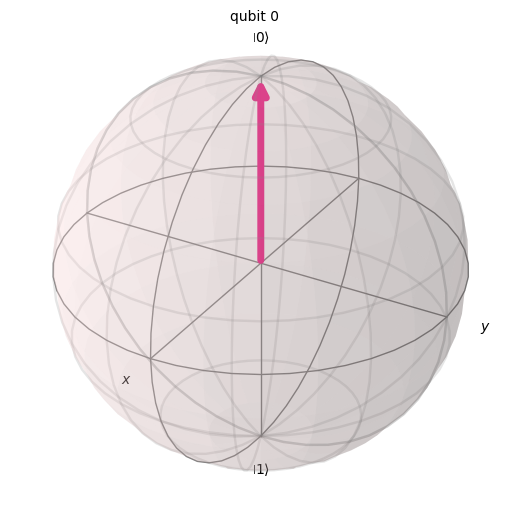

--- Circuit for |1>  (bit=1, basis=+) ---


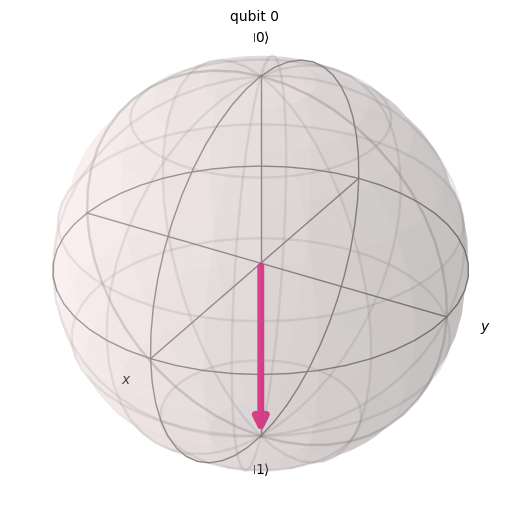

--- Circuit for |+>  (bit=0, basis=x) ---


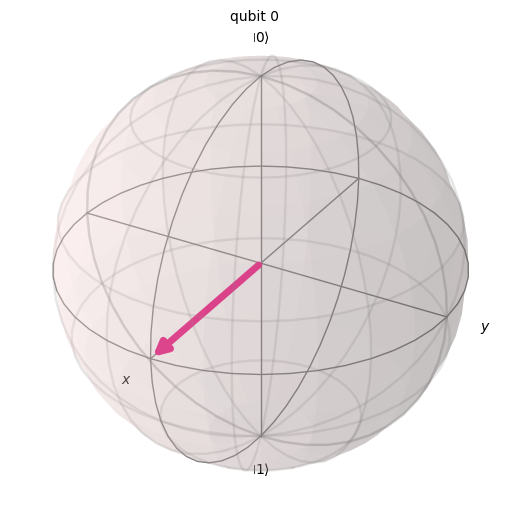

--- Circuit for |->  (bit=1, basis=x) ---


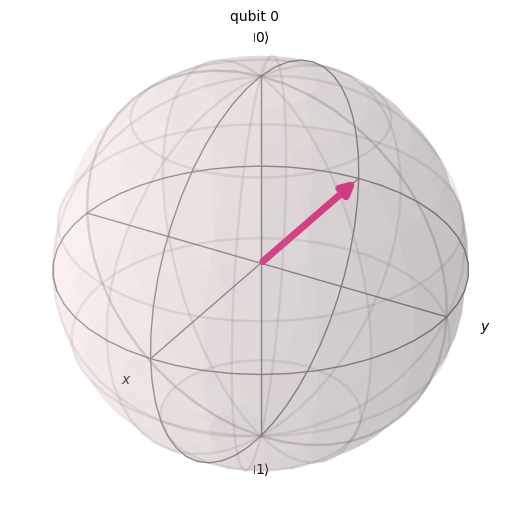

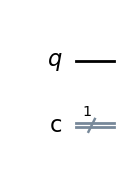

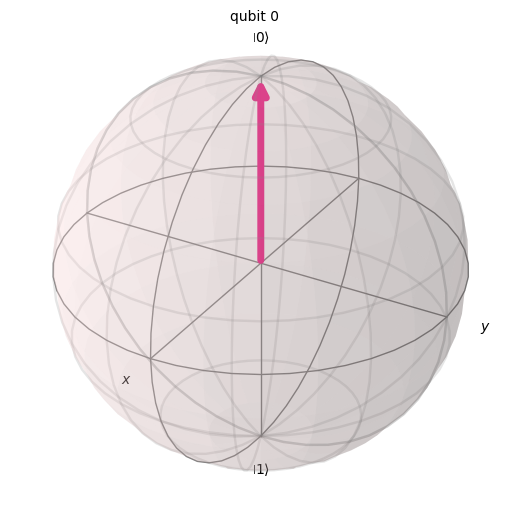

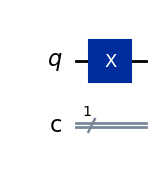

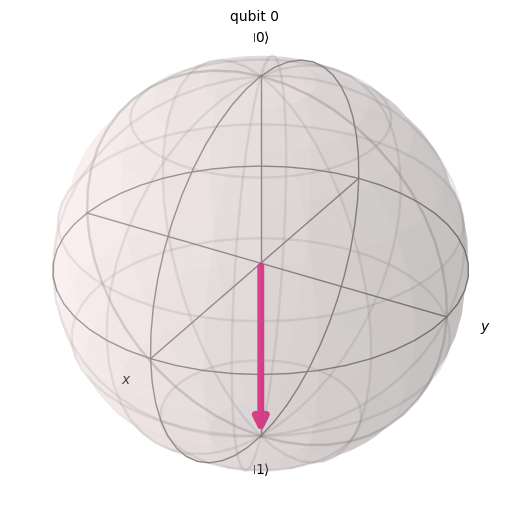

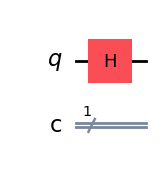

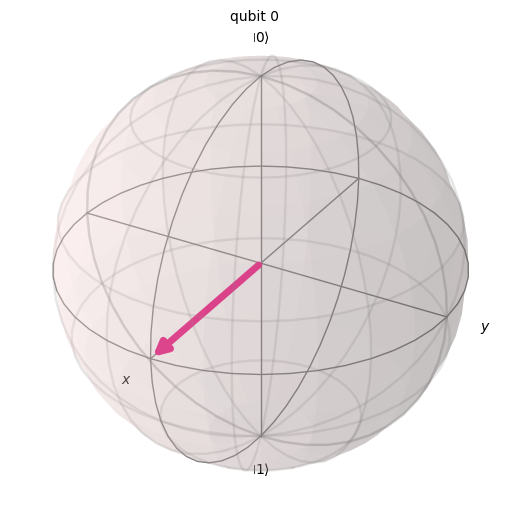

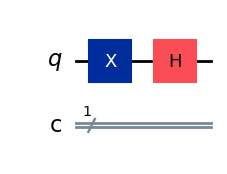

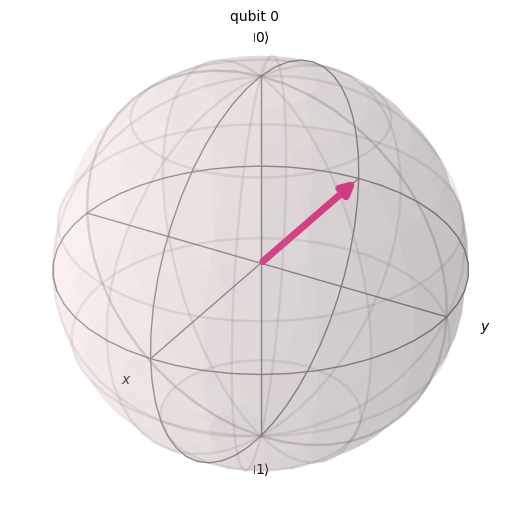

In [ ]:
# State visualization
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

states = [
    ("|0>  (bit=0, basis=+)", prepare_bb84_state(0, '+')),
    ("|1>  (bit=1, basis=+)", prepare_bb84_state(1, '+')),
    ("|+>  (bit=0, basis=x)", prepare_bb84_state(0, 'x')),
    ("|->  (bit=1, basis=x)", prepare_bb84_state(1, 'x')),
]

for label, qc in states:
    print(f"--- Circuit for {label} ---")
    qc.draw("mpl");
    # get statevector without running a simulator
    sv = Statevector.from_instruction(qc)
    display(plot_bloch_multivector(sv))


In [27]:
def single_pulse_transmission(alice_bit, alice_basis, bob_basis, eve_intercepts=False, eve_basis=None, noise_flip_prob=0.0):
    """
    Simulate one BB84 pulse:
      - Use Qiskit circuit to prepare Alice's state.
      - If eve_intercepts True: Eve measures in eve_basis (random if None) then re-prepares and forwards.
      - Bob measures in bob_basis (applying H if needed).
      - noise_flip_prob: models channel/detector error as a classical flip applied to Bob's measurement result.
    Returns: bob_measured_bit (int), eve_info (None or dict)
    """
    # Prepare Alice state
    qc_a = prepare_bb84_state(alice_bit, alice_basis)
    
    # If Eve intercepts:
    if eve_intercepts:
        eve_basis_choice = eve_basis if eve_basis is not None else random.choice(['+','x'])
        # Eve measures Alice's state in eve_basis -> get result
        qc_e = qc_a.copy()
        qc_e = measure_in_basis(qc_e, eve_basis_choice)
        job_e = backend.run(transpile(qc_e, backend=backend), shots=1)
        res_e = job_e.result().get_counts()
        # counts is dict like {'0':1} or {'1':1}
        eve_meas = int(list(res_e.keys())[0])
        # Eve resends a new qubit prepared according to her measurement result in the same basis she used
        qc_forward = prepare_bb84_state(eve_meas, eve_basis_choice)
        # Now Bob measures
        qc_forward = measure_in_basis(qc_forward, bob_basis)
        job_b = backend.run(transpile(qc_forward, backend=backend), shots=1)
        res_b = job_b.result().get_counts()
        bob_bit = int(list(res_b.keys())[0])
        # apply classical noise flip
        if random.random() < noise_flip_prob:
            bob_bit = 1 - bob_bit
        eve_info = {'eve_basis': eve_basis_choice, 'eve_result': eve_meas}
        return bob_bit, eve_info
    else:
        # No Eve: direct forward of Alice's prepared state to Bob
        qc_b = qc_a.copy()
        qc_b = measure_in_basis(qc_b, bob_basis)
        job = backend.run(transpile(qc_b, backend=backend), shots=1)
        res = job.result().get_counts()
        bob_bit = int(list(res.keys())[0])
        if random.random() < noise_flip_prob:
            bob_bit = 1 - bob_bit
        return bob_bit, None


In [28]:
def generate_alice_sequence(n):
    bits = np.random.randint(0,2,size=n)
    bases = np.random.choice(['+','x'], size=n)
    return bits, bases

def run_bb84(n_bits=200, eve_intercept_prob=0.0, channel_noise=0.0):
    """
    Simulate n_bits transmissions. Eve intercepts each pulse independently with probability eve_intercept_prob.
    channel_noise is the classical flip probability applied to Bob's measurement (models channel/detector errors).
    Returns:
      alice_bits, alice_bases, bob_results, bob_bases, intercepted_flags
    """
    alice_bits, alice_bases = generate_alice_sequence(n_bits)
    bob_bases = np.random.choice(['+','x'], size=n_bits)
    bob_results = np.zeros(n_bits, dtype=int)
    intercepted_flags = np.zeros(n_bits, dtype=bool)
    eve_records = [None]*n_bits

    for i in range(n_bits):
        if random.random() < eve_intercept_prob:
            bob_bit, eve_info = single_pulse_transmission(alice_bits[i], alice_bases[i], bob_bases[i],
                                                          eve_intercepts=True, eve_basis=None, noise_flip_prob=channel_noise)
            intercepted_flags[i] = True
            eve_records[i] = eve_info
        else:
            bob_bit, _ = single_pulse_transmission(alice_bits[i], alice_bases[i], bob_bases[i],
                                                   eve_intercepts=False, noise_flip_prob=channel_noise)
        bob_results[i] = bob_bit

    return alice_bits, alice_bases, bob_results, bob_bases, intercepted_flags, eve_records

def sift_key_and_estimate_qber(alice_bits, alice_bases, bob_results, bob_bases, sample_fraction=0.2):
    mask = (alice_bases == bob_bases)
    alice_key = alice_bits[mask]
    bob_key = bob_results[mask]
    n = len(alice_key)
    if n == 0:
        return alice_key, bob_key, None, []
    k = max(1, int(sample_fraction * n))
    idx = np.random.choice(n, size=k, replace=False)
    qber = np.sum(alice_key[idx] != bob_key[idx]) / k
    return alice_key, bob_key, qber, sorted(idx)


In [29]:
alice_bits, alice_bases, bob_results, bob_bases, intercepted_flags, _ = run_bb84(n_bits=200, eve_intercept_prob=0.0, channel_noise=0.01)
alice_key, bob_key, qber_est, revealed = sift_key_and_estimate_qber(alice_bits, alice_bases, bob_results, bob_bases, sample_fraction=0.25)
print("Raw key length:", len(alice_key))
print("Estimated QBER (no Eve, small channel noise):", qber_est)


Raw key length: 106
Estimated QBER (no Eve, small channel noise): 0.0


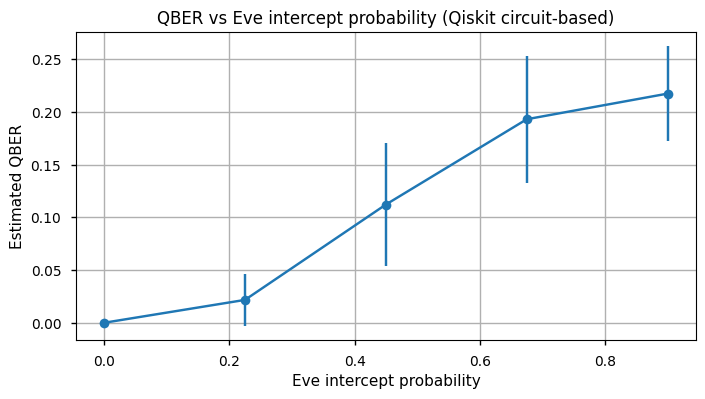

In [31]:
ps = np.linspace(0, 0.9, 5)
mean_qbers = []
std_qbers = []
trials_per_p = 6

for p in ps:
    qbers = []
    for _ in range(trials_per_p):
        a_bits, a_bases, b_res, b_bases, intercepted, _ = run_bb84(n_bits=200, eve_intercept_prob=p, channel_noise=0.0)
        _, _, qber, _ = sift_key_and_estimate_qber(a_bits, a_bases, b_res, b_bases, sample_fraction=0.3)
        qbers.append(0.0 if qber is None else qber)
    mean_qbers.append(np.mean(qbers))
    std_qbers.append(np.std(qbers))

plt.figure(figsize=(8,4))
plt.errorbar(ps, mean_qbers, yerr=std_qbers, fmt='-o')
plt.xlabel('Eve intercept probability')
plt.ylabel('Estimated QBER')
plt.title('QBER vs Eve intercept probability (Qiskit circuit-based)')
plt.grid(True)
plt.show()


## **Decoy-State BB84 Extension**

Photon Number Splitting (PNS) attacks are a serious weakness in weak-coherent-pulse QKD.  
To counter this, we implement the **decoy-state method**, where Alice sends pulses of three types:

- **Signal state** → Normal intensity  
- **Decoy state** → Lower intensity  
- **Vacuum state** → Zero photons

Bob compares detection rates and QBER of each category.

### **Security Insight**
If Eve attempts a PNS attack:
- Decoy & vacuum statistics differ significantly  
- Bob detects the mismatch  
- The key is discarded
 

This verifies the integrity of the channel under different photon intensities.


In [ ]:
def run_decoy_bb84(n_bits=2000,
                   signal_prob=0.7,
                   decoy_prob=0.2,
                   vacuum_prob=0.1,
                   eve_intercept_prob=0.0,
                   channel_noise=0.0):
    """
    A wrapper around existing BB84 functions that adds:
    - signal pulses
    - decoy pulses
    - vacuum pulses
    """

    # ✔ Assign each pulse a type
    labels = []
    for _ in range(n_bits):
        r = np.random.rand()
        if r < signal_prob:
            labels.append("signal")
        elif r < signal_prob + decoy_prob:
            labels.append("decoy")
        else:
            labels.append("vacuum")
    labels = np.array(labels)

    # ✔ Detection probabilities for each pulse type
    # (vacuum pulses often won't generate a detection)
    detect_prob = {"signal": 1.0, "decoy": 0.5, "vacuum": 0.05}
    
    # ---- RUN BB84 ( existing function) ----
    (
        alice_bits,
        alice_bases,
        bob_results,
        bob_bases,
        intercepted_flags,
        eve_info
    ) = run_bb84(n_bits, eve_intercept_prob, channel_noise)

    # ---- Apply decoy detection probability ----
    effective_bob = []
    for i in range(n_bits):
        p = detect_prob[labels[i]]
        if np.random.rand() < p:
            effective_bob.append(bob_results[i])
        else:
            # "lost" detection → assign None
            effective_bob.append(None)
    effective_bob = np.array(effective_bob, dtype=object)

    # ---- Only keep positions where Bob actually detected ----
    valid_mask = effective_bob != None

    alice_bits_valid = alice_bits[valid_mask]
    alice_bases_valid = alice_bases[valid_mask]
    bob_results_valid = effective_bob[valid_mask]
    bob_bases_valid = bob_bases[valid_mask]
    labels_valid = labels[valid_mask]

    # ---- Compute QBER per pulse type ----
    qber_results = {}
    for t in ["signal", "decoy", "vacuum"]:
        mask = labels_valid == t
        if np.sum(mask) > 3:
            _, _, qber, _ = sift_key_and_estimate_qber(
                alice_bits_valid[mask],
                alice_bases_valid[mask],
                bob_results_valid[mask],
                bob_bases_valid[mask]
            )
        else:
            qber = None
        qber_results[t] = qber

    return {
        "labels": labels_valid,
        "alice_bits": alice_bits_valid,
        "bob_bits": bob_results_valid,
        "alice_bases": alice_bases_valid,
        "bob_bases": bob_bases_valid,
        "qber_signal": qber_results["signal"],
        "qber_decoy": qber_results["decoy"],
        "qber_vacuum": qber_results["vacuum"],
    }


In [ ]:
res = run_decoy_bb84(
    n_bits=200,
    eve_intercept_prob=0.2,
    channel_noise=0.02
)

print("---- Decoy-State BB84 ----")
print("Signal QBER:", res["qber_signal"])
print("Decoy QBER :", res["qber_decoy"])
print("Vacuum QBER:", res["qber_vacuum"])


---- Decoy-State BB84 ----
Signal QBER: 0.13333333333333333
Decoy QBER : 0.0
Vacuum QBER: None


More insightfull results could be derived by setting nbits > 2000 . Here nbits was set to 200 due to computational time.

## **Conclusion**

This notebook demonstrates a complete and well-visualized BB84 QKD simulation with noise modeling.  
The added **Decoy-State BB84** section significantly improves security by detecting PNS attacks.

### **Key Learnings**
- How quantum states encode information  
- How noise affects qubit measurements  
- Real QKD security techniques beyond standard BB84  
- How to compute and interpret QBER    
